### Load standard libraries



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from collections import Counter
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from scipy.stats import linregress
from scipy.stats import circmean
from scipy.stats import circvar
from skimage.transform import rescale

### Load data
The data is Google Drive's fontclosgpu@gmail.com account. We **mount** the drive and untar the data in the ephemeral Google Colab instance we have been given.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Set basedir where we are going to operate

In [4]:
BASEDIR = Path("/content/drive/MyDrive/silicanets-data/")


We first read just the metadata, which has paths to images and targets. A first version of the metadata csv ommited the box sizes, so a new one has been uploaded to drive, outside the main tar.

### Set global parameters
Here we choose the number of runs, number of samples, max training epochs and dropout level.

In [5]:
# choose training dataset
training_data_disorder_variance = "variable"

if isinstance(training_data_disorder_variance, float):
  varcode = str(int(10 * training_data_disorder_variance))
  compressed_data = f"ml_dataset_var0{varcode}.tar.gz"

elif training_data_disorder_variance == "variable":
  compressed_data = "ml_dataset_variable_var.tar.gz"

else:
  raise NotImplementedError


try:
  df = pd.read_csv("ml_dataset/metadata.csv")
except:
  ! tar xzf {BASEDIR / "data" / compressed_data}
  df = pd.read_csv("ml_dataset/metadata.csv")


try:
  del history_df
except:
  pass

num_samples = "all" # a number or "all"
num_runs = "all" # a number or "all"
max_epochs = 100
dropout = 0
scale = 0.5


loss_str = "mse_plus_bias_term"
assert loss_str in ["mse_plus_bias_term", "mse"]

# for the lazy types
if num_samples == "all":
  num_samples = len(df)
if num_runs == "all":
  num_runs = len(df.run.unique())

assert num_runs <= len(df.run.unique())


In [6]:
if training_data_disorder_variance == "variable":
  disorder_df = pd.read_csv(BASEDIR / "data" / "variable_disorder_missing_metadata_column.txt", header=None, sep=" ", names=["run", "disorder"])
  disorder_df["run"] = disorder_df.run.apply(lambda x: f"run_{x:05d}")
  df["disorder_var"] = df.run.map(dict(disorder_df.values))

### Subsample data
Simply subsample uniformely since therer is no issue here.
First select a subset of runs, this is just to study the effect of number of runs on final accuracy

In [7]:
assert num_runs <= len(df.run.unique())
valid_runs = np.random.choice(df.run.unique(), size=num_runs, replace=False)
_idx = df.run.apply(lambda x: x in valid_runs)
df = df.loc[_idx].copy()

just downsampling

In [8]:
df_subsampled = df.sample(num_samples)

### Create output dir
Create a new, unique directory to store all outputs of this round.

In [9]:
import datetime
model_name = "resnet-location1d-" + datetime.datetime.now().isoformat().split(".")[0]
! mkdir -p {BASEDIR / "output" / model_name / "checkpoints_0"}
! mkdir -p {BASEDIR / "output" / model_name / "checkpoints_1"}
! mkdir -p {BASEDIR / "output" / model_name / "dataframes"}
! mkdir -p {BASEDIR / "output" / model_name / "figures"}



In [10]:
num_runs = len(df_subsampled.run.unique())
num_images = len(df_subsampled)

In [11]:
info = {
    "model_name": model_name,
    "num_runs": num_runs,
    "num_images": num_images,
    "max_epochs": max_epochs,
    "dropout": dropout,
    "scale": scale,
    "disorder_variance": training_data_disorder_variance,
    "loss": loss_str
}

In [12]:
pd.Series(info).to_csv(BASEDIR / "output" / model_name / "model_info.csv")


Save dfs for reproducibility

In [13]:
pd.to_pickle(df, BASEDIR / "output" / model_name / "dataframes" / "df.p")
pd.to_pickle(df_subsampled, BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")

### Split data
We need to split the data into the standard train, validation, test sets, but respecting the original runs (otherwise we have copies of same run in different sets which is not ok)

In [14]:
def data_splitter(df, test_split=0.2):
  """Split the metadata dataframe into train and test sets
  keeping runs together, that is, not allowing different images
  of the same run to be in different sets.
  """
  runs_all = df["run"].unique()
  _run_splitter = int((1 - test_split) * len(runs_all))
  np.random.shuffle(runs_all)
  runs_train = runs_all[:_run_splitter]
  runs_test = runs_all[_run_splitter:]
  _idx_train = df.run.apply(lambda x: x in runs_train)
  _idx_test = df.run.apply(lambda x: x in runs_test)
  df_train = df.loc[_idx_train]
  df_test = df.loc[_idx_test]

  return df_train, df_test

In [15]:
df_train, df_test = data_splitter(df_subsampled, test_split=0.2)
df_train, df_validation = data_splitter(df_train, test_split=0.1)

In [16]:
print(f"Saving metadata of train, test, validation for reproducibility:")
print(f"Train set: {len(df_train.run.unique())} runs ({len(df_train)} images)")
print(f"Validation set: {len(df_validation.run.unique())} runs ({len(df_validation)} images)")
print(f"Test set: {len(df_test.run.unique())} runs ({len(df_test)} images)")

df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
df_validation.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")

Saving metadata of train, test, validation for reproducibility:
Train set: 437 runs (27968 images)
Validation set: 49 runs (3136 images)
Test set: 122 runs (7808 images)


### Load images
We load all images into memory. 
So far this works, but we are close to our memory limits.
We might need to use keras DataGenerators in the future.

In [17]:
def get_xy_from_df(df, scale: float=1.0):
    X = []
    y = []
    for _, sample in df.iterrows():
        _X = rescale(plt.imread(sample["image"]), scale=scale)
        _y = [sample["relative_break_location_x"], sample["relative_break_location_y"]]
        X.append(_X)
        y.append(_y)
    X = np.array(X)
    y = np.array(y)
    X = np.expand_dims(X, -1)
    return X, y

In [18]:
X_train, y_train = get_xy_from_df(df_train, scale=scale)
X_validation, y_validation = get_xy_from_df(df_validation, scale=scale)
X_test, y_test = get_xy_from_df(df_test, scale=scale)

### Feature normalization
We rescale features only, using train test to learn only to avoid data leaking.

In [19]:
_m = np.mean(X_train, axis=0)
_s = np.std(X_train, axis=0)

X_train = ((X_train - _m) / _s)
X_validation = ((X_validation - _m) / _s)
X_test =  ((X_test - _m) / _s)

In [20]:
train_data_rescale_params = {
    "mean": _m,
    "std": _s
}
pd.to_pickle(train_data_rescale_params, BASEDIR / "output" / model_name / "dataframes" / "train_data_rescale_params.p")

In [21]:
pd.to_pickle(X_train, BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
pd.to_pickle(X_validation, BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
pd.to_pickle(X_test, BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

pd.to_pickle(y_train, BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
pd.to_pickle(y_validation, BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
pd.to_pickle(y_test, BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

### Crash recover
Uncomment this cell and run to recover from a crash after training.
Remember to skip training if you do this!

In [ ]:
if True:
  model_name = "resnet-location1d-2021-04-26T10:19:44"

  df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df.p")
  df_subsampled = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")
  df_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
  df_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
  df_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")


  X_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
  X_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
  X_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

  y_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
  y_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
  y_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

  history_df_0 = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df_0.p")
  history_df_1 = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df_1.p")

  # recover important settings
  info = dict(pd.read_csv(BASEDIR / "output" / model_name / "model_info.csv").values)
  dropout = float(info["dropout"])
  loss_str = info["loss"]

  try:
    training_data_disorder_variance = float(info["disorder_variance"])
  except:
    training_data_disorder_variance = str(info["disorder_variance"])



### Loss function and PBC
We use a custom PBC-aware loss function. The loss function is hard-coded with some given box size, which we infer from the training data only.

In [22]:
def mic_tf(x: np.ndarray, L=None) -> np.array:
  """Minimum image convention in tensorflow.
  
  Assume x is a distance in mod L space.
  """
  return -L/2 + tf.math.mod(x + L/2, L)

def mic(x: np.ndarray, L=None) -> np.array:
  """Minimum image convention in numpy, assume x is a dinstace in mod L space."""
  return -L/2 + np.mod(x + L/2, L)



In [23]:
def pbc_loss_mse(y_true, y_pred):
  """
  PBC-aware mean-squared error loss.

  Assuming mod 1 space, computes MSE taking distances between -0.5 and 0.5.
  Works well with relative box units.
  """
  y_diff = y_true - y_pred
  # compute squared differences using minimum image convention
  squared_difference = tf.square(mic_tf(y_diff, L=1))

  # use tensorflow reduce operations for speed
  loss = tf.reduce_mean(squared_difference, axis=-1)
  return loss

In [24]:
def pbc_loss_mse_plus_bias(y_true, y_pred):
  """
  PBC-aware modified mean-squared error loss.

  Assuming mod 1 space, computes modified MSE taking distances between -0.5 and 0.5.
  Works well with relative box units.

  This loss has two terms:
  L1 = mean-squared error
  L2 = squared difference of means (bias-only term)

  In this way, more weight is given to the bias part of the loss (bias-variance
  decomposition). This helps avoiding solutions with low variance but high bias,
  such as a perfect fit on slope < 1 line.
  """
  y_diff = y_true - y_pred
  # compute squared differences using minimum image convention
  squared_difference = tf.square(mic_tf(y_diff, L=1))
  # use tensorflow reduce operations for speed
  loss1 = tf.reduce_mean(squared_difference, axis=-1)

  # add a second loss to add more weigth to bias
  m = tf.reduce_mean(y_true, axis=-1)
  m_pred = tf.reduce_mean(y_pred, axis=-1)

  loss2 = (m - m_pred)**2 

  # total loss is sum of two losses
  loss = loss1 + loss2
  return loss


We choose the loss function according to the string selected in the global parameters section of the notebook.

In [25]:
pbc_loss = {
    "mse_plus_bias_term": pbc_loss_mse_plus_bias,
    "mse": pbc_loss_mse
}[loss_str]

### Model setup
We use a simple keras + dropout + dense scheme. We use two models, one for x and one for y. To avoid making a mess, we call them model_0 (y[0]) and model_1 (y[1])

In [26]:
def get_model(dropout: float = 0.2):
  premaid = tf.keras.applications.ResNet50(
      include_top=False,
      pooling="avg",
      weights=None,
      input_shape=X_train[0].shape,
  )

  model = tf.keras.models.Sequential()
  model.add(premaid)
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss=pbc_loss, optimizer="adam")
  return model

In [27]:
model_0 = get_model(dropout=dropout)
model_1 = get_model(dropout=dropout)

### Model training
We train for a few epochs, saving weights of best epoch.



In [28]:
checkpoint_filepath_0 = BASEDIR / "output" / model_name / "checkpoints_0/checkpoint" 

In [29]:
callbacks_0 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_0,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        ),
]

In [30]:
history_0 = model_0.fit(
    X_train, y_train.T[0].T,
    validation_data = (X_validation, y_validation.T[0].T),
    epochs=max_epochs,
    callbacks=callbacks_0
)
try:
  history_df_0 = pd.concat([history_df_0, pd.DataFrame(history_0.history)])
  history_df_0.index = range(len(history_df_0))
except:
  history_df_0 = pd.DataFrame(history_0.history)

Epoch 1/100
874/874 [==============================] - 86s 79ms/step - loss: 0.3144 - val_loss: 0.5755
Epoch 2/100
874/874 [==============================] - 66s 76ms/step - loss: 0.2269 - val_loss: 1.5331
Epoch 3/100
874/874 [==============================] - 69s 79ms/step - loss: 0.1966 - val_loss: 0.2123
Epoch 4/100
874/874 [==============================] - 66s 76ms/step - loss: 0.1899 - val_loss: 2.2452
Epoch 5/100
874/874 [==============================] - 66s 76ms/step - loss: 0.1906 - val_loss: 0.3521
Epoch 6/100
874/874 [==============================] - 67s 77ms/step - loss: 0.1781 - val_loss: 0.1562
Epoch 7/100
874/874 [==============================] - 66s 76ms/step - loss: 0.1746 - val_loss: 0.3800
Epoch 8/100
874/874 [==============================] - 66s 76ms/step - loss: 0.1675 - val_loss: 1.5256
Epoch 9/100
874/874 [==============================] - 66s 76ms/step - loss: 0.1616 - val_loss: 0.2279
Epoch 10/100
874/874 [==============================] - 66s 76ms/step - l

In [31]:
checkpoint_filepath_1 = BASEDIR / "output" / model_name / "checkpoints_1/checkpoint" 

In [32]:
callbacks_1 = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_1,
        monitor="val_loss",
        save_weights_only=True,
        save_best_only=True,
        ),
]

In [33]:
history_1 = model_1.fit(
    X_train, y_train.T[1].T,
    validation_data = (X_validation, y_validation.T[1].T),
    epochs=max_epochs,
    callbacks=callbacks_1
)
try:
  history_df_1 = pd.concat([history_df_1, pd.DataFrame(history_1.history)])
  history_df_1.index = range(len(history_df_1))
except:
  history_df_1 = pd.DataFrame(history_1.history)

Epoch 1/100
874/874 [==============================] - 74s 79ms/step - loss: 0.3020 - val_loss: 0.2453
Epoch 2/100
874/874 [==============================] - 67s 77ms/step - loss: 0.2110 - val_loss: 2.9022
Epoch 3/100
874/874 [==============================] - 68s 78ms/step - loss: 0.1992 - val_loss: 0.1965
Epoch 4/100
874/874 [==============================] - 67s 77ms/step - loss: 0.1747 - val_loss: 0.2290
Epoch 5/100
874/874 [==============================] - 67s 77ms/step - loss: 0.1626 - val_loss: 0.7221
Epoch 6/100
874/874 [==============================] - 69s 79ms/step - loss: 0.1495 - val_loss: 0.1301
Epoch 7/100
874/874 [==============================] - 67s 77ms/step - loss: 0.1405 - val_loss: 0.6984
Epoch 8/100
874/874 [==============================] - 68s 78ms/step - loss: 0.1456 - val_loss: 0.1162
Epoch 9/100
874/874 [==============================] - 67s 77ms/step - loss: 0.1249 - val_loss: 0.1323
Epoch 10/100
874/874 [==============================] - 67s 77ms/step - l

### Model predictions
We just unpack the x,y components of the predictions and wrap them around the PBC. To do this, we need to define box size cohererntly for all runs...

In [34]:
model_0.load_weights(checkpoint_filepath_0)
model_1.load_weights(checkpoint_filepath_1)

In [35]:
y_test_pred_x = model_0.predict(X_test)
y_test_pred_y = model_1.predict(X_test)

y_train_pred_x = model_0.predict(X_train)
y_train_pred_y = model_1.predict(X_train)

In [36]:
raw_results_df_test = df_test.copy()
raw_results_df_test["prediction_relative_break_location_x"] = y_test_pred_x
raw_results_df_test["prediction_relative_break_location_y"] = y_test_pred_y

raw_results_df_train = df_train.copy()
raw_results_df_train["prediction_relative_break_location_x"] = y_train_pred_x
raw_results_df_train["prediction_relative_break_location_y"] = y_train_pred_y


### Average over data augmentation
We average predictions over data augmentation so that we can give a unique prediction for each configuration. This is known as consensus prediction and will give lower variance and same bias in predictions.

In [37]:
def compute_prediction_relative_original_break_location(raw_results_df):
  """Invert the translation and h/v flip operations to recover coordinates of
  predictions in original, non-data-augmented space.
  """
  raw_results_df["prediction_relative_original_break_location_x"] = \
    raw_results_df.horizontal_flip * (1 - raw_results_df.prediction_relative_break_location_x) + \
    (1 - raw_results_df.horizontal_flip) * (raw_results_df.prediction_relative_break_location_x) \
    - raw_results_df.relative_translation_x

  raw_results_df["prediction_relative_original_break_location_y"] = \
    raw_results_df.vertical_flip * (1 - raw_results_df.prediction_relative_break_location_y) + \
    (1 - raw_results_df.vertical_flip) * (raw_results_df.prediction_relative_break_location_y) \
    - raw_results_df.relative_translation_y

In [38]:
def average_out_data_augmentation(raw_results_df):
  """Compute the average of predictions corresponding to the same configuration
  using circular mean between 0 and 1.
  """
  _tokeep = [
    "box_size_x", "box_size_y", "break_strain", "disorder_var",
    "absolute_original_break_location_x",
    "absolute_original_break_location_y",
    "relative_original_break_location_x",
    "relative_original_break_location_y"
  ]
  results_df = raw_results_df.groupby("run").mean()[_tokeep]
  results_df["prediction_relative_original_break_location_x"] = raw_results_df.groupby("run")["prediction_relative_original_break_location_x"].apply(lambda x: circmean(x, high=1))
  results_df["prediction_relative_original_break_location_y"] = raw_results_df.groupby("run")["prediction_relative_original_break_location_y"].apply(lambda x: circmean(x, high=1))
  return results_df

In [39]:
compute_prediction_relative_original_break_location(raw_results_df_train)
compute_prediction_relative_original_break_location(raw_results_df_test)

In [40]:
results_df_test = average_out_data_augmentation(raw_results_df_test)
results_df_train = average_out_data_augmentation(raw_results_df_train)

In [41]:
raw_results_df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "raw_results_df_train.p")
raw_results_df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "raw_results_df_test.p")
results_df_train.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "results_df_train.p")
results_df_test.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "results_df_test.p")

history_df_0.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df_0.p")
history_df_1.to_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df_1.p")

### Plot results

In [42]:
def plot_results_onecoord(results_df, label, wrap=True):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True, tight_layout=True)
  ax = ax1
  ax.set_aspect(1)
  ax.plot([0, 1], [0, 1], ls="dashed", c="0.2")
  ax.axhline(0, c="0.2", lw=1, ls="dotted")
  ax.axhline(1, c="0.2", lw=1, ls="dotted")

  _x = results_df.relative_original_break_location_x
  _y = results_df.prediction_relative_original_break_location_x
  ax.scatter(
    _x,
    _x + mic(_y - _x, L=1),
    s=40,
    color="red"
  )
  ax.set_xlabel("Rupture locus x-coord")
  ax.set_ylabel("Model prediction")
  ax.set_title(label)

  ax = ax2
  ax.set_aspect(1)
  ax.plot([0, 1], [0, 1], ls="dashed", c="0.2")
  ax.axhline(0, c="0.2", lw=1, ls="dotted")
  ax.axhline(1, c="0.2", lw=1, ls="dotted")

  _x = results_df.relative_original_break_location_y
  _y = results_df.prediction_relative_original_break_location_y
  _yy = _y
  if wrap:
    _yy = _x + mic(_y - _x, L=1)
  
  ax.scatter(
    _x,
    _x + mic(_y - _x, L=1),
    s=40,
    color="red"
  )
  ax.set_xlabel("Rupture locus y-coord")
  ax.set_ylabel("Model prediction")
  ax.set_title(label)


  return fig, ax

In [43]:
def plot_results_twocoord(results_df, label):
  # compute errors
  _x = results_df.relative_original_break_location_x
  _xp = results_df.prediction_relative_original_break_location_x
  _y = results_df.relative_original_break_location_y
  _yp = results_df.prediction_relative_original_break_location_y
  err_x = mic(_x - _xp, L=1)
  err_y = mic(_y - _yp, L=1)

  g = sns.jointplot(x=err_x, y=err_y, height=4, color="0.2")
  g.set_axis_labels(xlabel="X error", ylabel="Y error")
  g.ax_joint.set_xticks([-0.5, -0.25, 0, 0.25, 0.5]);
  g.ax_joint.set_yticks([-0.5, -0.25, 0, 0.25, 0.5]);
  g.fig.suptitle(label, fontsize=14)
  g.fig.tight_layout()
  g.fig.subplots_adjust(top=0.9)
  return g

In [44]:
def plot_history(history_df: pd.DataFrame):
  fig, ax = plt.subplots(1, 1, figsize=(5, 4))
  ax.plot(history_df.loss, marker="o", ms=7, label="Train set", color=colors_dict["TRAIN SET"])
  ax.plot(history_df.val_loss, marker="o", ms=7, label="Validation set", color=colors_dict["VALIDATION SET"])
  ax.legend(frameon=False)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss function (MSE)")
  ax.set_yscale("log")
  return fig, ax

In [45]:
colors_dict = {
    "TRAIN SET":"0.5",
    "VALIDATION SET": "#ff2d55",
    "TEST SET": "#007aff",
}

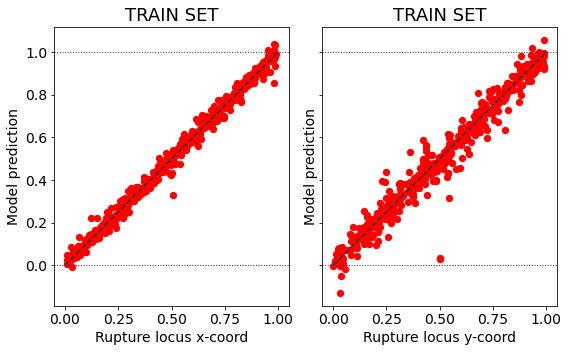

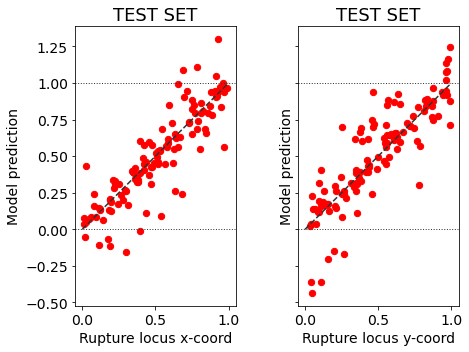

In [46]:
fig, ax = plot_results_onecoord(results_df=results_df_train, label="TRAIN SET", wrap=False)
fig.savefig(BASEDIR / "output" / model_name / "figures" / "results_onecoord_train_set.png", dpi=150)

fig, ax = plot_results_onecoord(results_df=results_df_test, label="TEST SET", wrap=False)
fig.savefig(BASEDIR / "output" / model_name / "figures" / "results_onecoord_test_set.png", dpi=150)

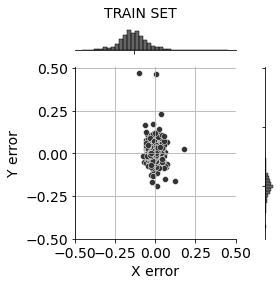

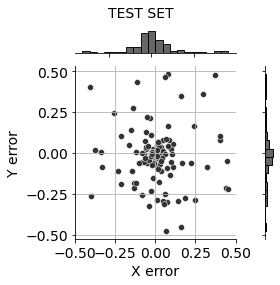

In [47]:
g = plot_results_twocoord(results_df=results_df_train, label="TRAIN SET")
g.ax_joint.grid()
g.savefig(BASEDIR / "output" / model_name / "figures" / "results_twocoord_train_set.png", dpi=150)

g = plot_results_twocoord(results_df=results_df_test, label="TEST SET")
g.ax_joint.grid()
g.savefig(BASEDIR / "output" / model_name / "figures" / "results_twocoord_test_set.png", dpi=150)

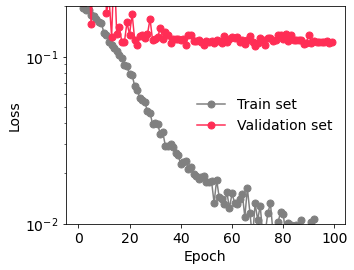

In [48]:
fig, ax = plot_history(history_df=history_df_0)
ax.set_ylim(1e-2, 0.2)
ax.set_ylabel("Loss")
fig.savefig(BASEDIR / "output" / model_name / "figures" / "loss_function_0.png", dpi=150)

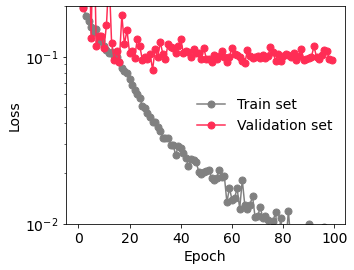

In [49]:
fig, ax = plot_history(history_df=history_df_1)
ax.set_ylim(1e-2, 0.2)
ax.set_ylabel("Loss")
fig.savefig(BASEDIR / "output" / model_name / "figures" / "loss_function_1.png", dpi=150)

(array([ 188.,  707.,  989., 1039., 1017.,  931., 1039.,  939.,  789.,
         170.]),
 array([-0.01114085,  0.09097254,  0.19308591,  0.2951993 ,  0.39731267,
         0.49942607,  0.60153943,  0.7036528 ,  0.8057662 ,  0.9078796 ,
         1.009993  ], dtype=float32),
 <a list of 10 Patch objects>)

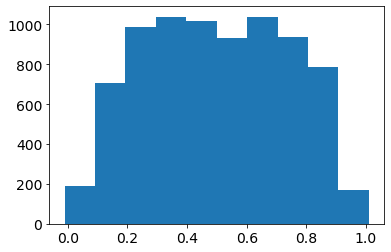

In [ ]:
plt.hist(y_test_pred_x)